In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [3]:
train_ds = torchvision.datasets.CIFAR10('/tmp/data', 
                                      train=True, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

test_ds  = torchvision.datasets.CIFAR10('/tmp/data', 
                                      train=False, 
                                      transform=torchvision.transforms.ToTensor(), # 将数据类型转化为Tensor
                                      download=True)

100%|██████████| 170M/170M [00:02<00:00, 61.3MB/s] 


In [4]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True)

test_dl  = torch.utils.data.DataLoader(test_ds, 
                                       batch_size=batch_size)

In [5]:
# 取一个批次查看数据格式
# 数据的shape为：[batch_size, channel, height, weight]
# 其中batch_size为自己设定，channel，height和weight分别是图片的通道数，高度和宽度。
imgs, labels = next(iter(train_dl))
imgs.shape

torch.Size([32, 3, 32, 32])

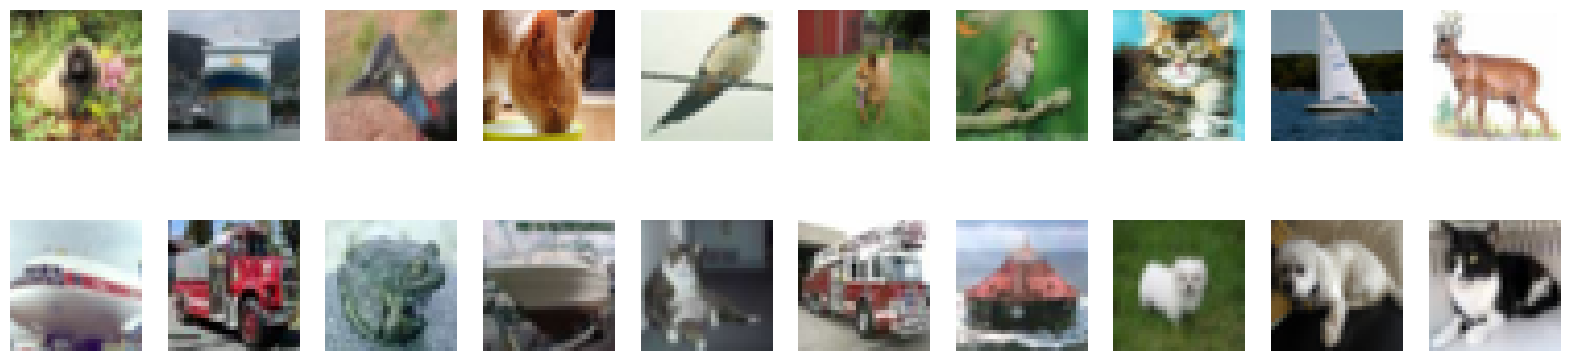

In [6]:
import numpy as np

# 指定图片大小，图像大小为20宽、5高的绘图(单位为英寸inch)
plt.figure(figsize=(20, 5)) 
for i, imgs in enumerate(imgs[:20]):
    # 进行轴变换
    npimg = imgs.numpy().transpose((1, 2, 0))
    # 将整个figure分成2行10列，绘制第i+1个子图。
    plt.subplot(2, 10, i+1)
    plt.imshow(npimg, cmap=plt.cm.binary)
    plt.axis('off')
    
#plt.show()  如果你使用的是Pycharm编译器，请加上这行代码

In [7]:
import torch.nn.functional as F

num_classes = 10  # 图片的类别数

class Model(nn.Module):
     def __init__(self):
        super().__init__()
         # 特征提取网络
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)   # 第一层卷积,卷积核大小为3*3
        self.pool1 = nn.MaxPool2d(kernel_size=2)       # 设置池化层，池化核大小为2*2
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)  # 第二层卷积,卷积核大小为3*3   
        self.pool2 = nn.MaxPool2d(kernel_size=2) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # 第二层卷积,卷积核大小为3*3   
        self.pool3 = nn.MaxPool2d(kernel_size=2) 
                                      
        # 分类网络
        self.fc1 = nn.Linear(512, 256)          
        self.fc2 = nn.Linear(256, num_classes)
     # 前向传播
     def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        return x

In [8]:
from torchinfo import summary
# 将模型转移到GPU中（我们模型运行均在GPU中进行）
model = Model().to(device)

summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Conv2d: 1-1                            1,792
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            36,928
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            131,328
├─Linear: 1-8                            2,570
Total params: 246,474
Trainable params: 246,474
Non-trainable params: 0

In [9]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-2 # 学习率
opt        = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [10]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小，一共60000张图片
    num_batches = len(dataloader)   # 批次数目，1875（60000/32）

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [11]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [12]:
epochs     = 10
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:16.1%, Train_loss:2.265, Test_acc:20.7%，Test_loss:2.128
Epoch: 2, Train_acc:26.4%, Train_loss:1.983, Test_acc:31.2%，Test_loss:1.867
Epoch: 3, Train_acc:35.6%, Train_loss:1.769, Test_acc:39.8%，Test_loss:1.642
Epoch: 4, Train_acc:41.7%, Train_loss:1.605, Test_acc:45.0%，Test_loss:1.527
Epoch: 5, Train_acc:45.6%, Train_loss:1.499, Test_acc:47.8%，Test_loss:1.461
Epoch: 6, Train_acc:49.5%, Train_loss:1.408, Test_acc:50.4%，Test_loss:1.382
Epoch: 7, Train_acc:52.2%, Train_loss:1.329, Test_acc:52.8%，Test_loss:1.302
Epoch: 8, Train_acc:54.9%, Train_loss:1.261, Test_acc:53.7%，Test_loss:1.305
Epoch: 9, Train_acc:57.5%, Train_loss:1.203, Test_acc:51.8%，Test_loss:1.352
Epoch:10, Train_acc:59.5%, Train_loss:1.146, Test_acc:53.5%，Test_loss:1.318
Done


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

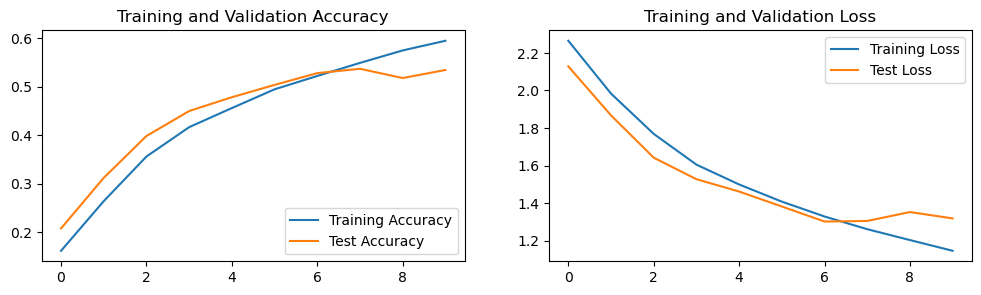

In [14]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

from datetime import datetime
current_time = datetime.now() # 获取当前时间

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#plt.xlabel(current_time) # 打卡请带上时间戳，否则代码截图无效

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()